
### Implementation notes
1. Use hourly dynamic *DemandAggregatedForecast, WindAggregatedForecast, MULTI_FUEL_-24, GAS_-24, GasPrice,CarbonPrice* data in the simulation.
2. Use 3 different thermal of Generators in the simulation: $cost = w_0*GasPrice + w_1*CarbonPrice$ ( [$w_0,w_1$] ∈{[0.66, 0.39], [0.69, 0.39], [0.79, 0.39]} ) ; $total_capacity = multi_fuel_-24 + gas_-24$
3. Use 1 wind generator in the simulation: $cost = 0$; $cpacity = WindAggregatedForecast$

### 0. Install & load the packages required

In [15]:
# ! pip3 install pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. load the Electricity data

In [16]:
data = pd.read_csv('data/Electricity_Data.csv')

### 2. Plot the GasPrice and CarbonPrice

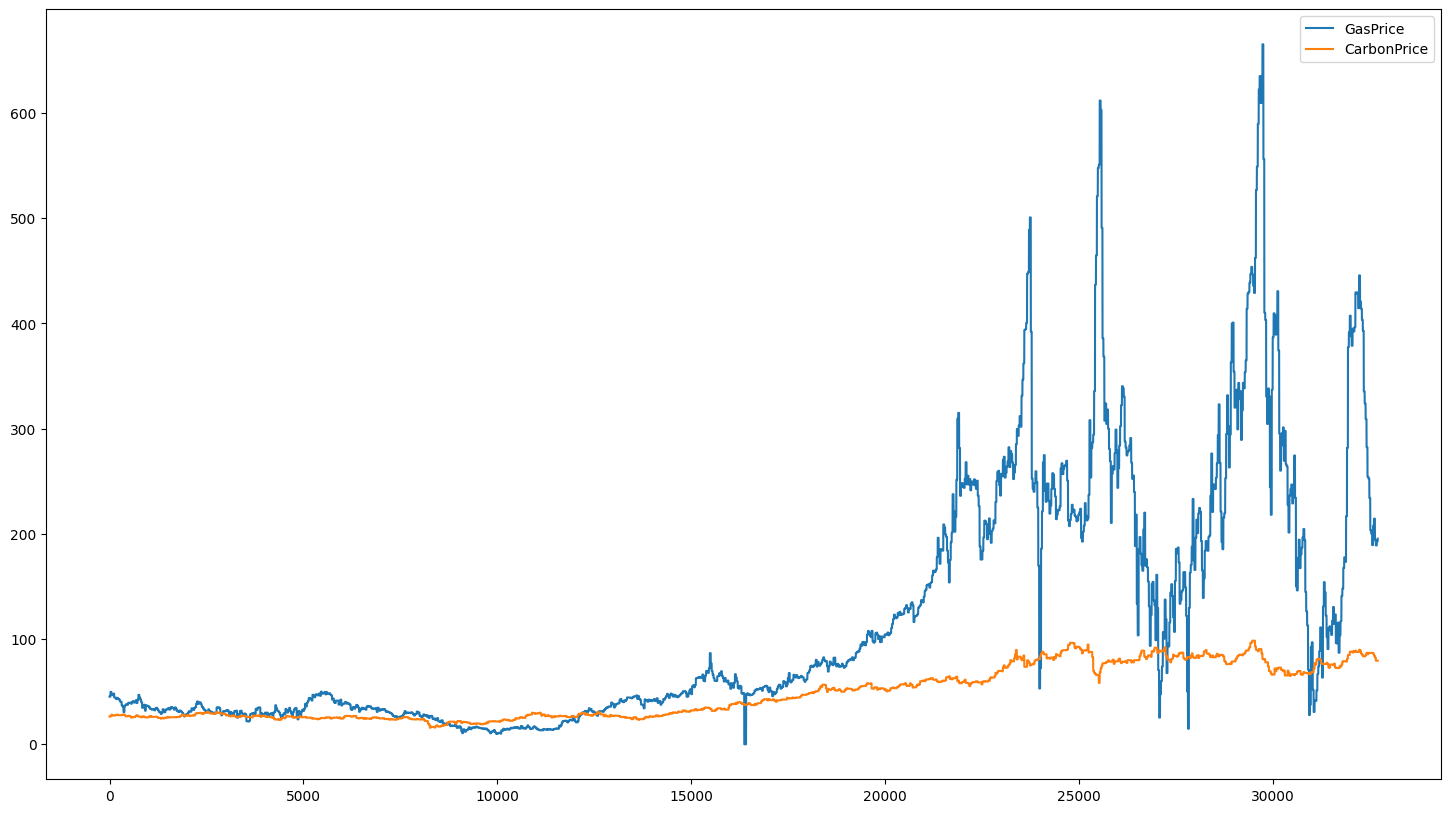

In [17]:
select_col = ['GasPrice', 'CarbonPrice']
plt.figure(figsize=(18, 10))
plt.plot(data[ select_col], label=select_col)
plt.legend()
plt.show()

### 3. Choose a period of data with lower variance

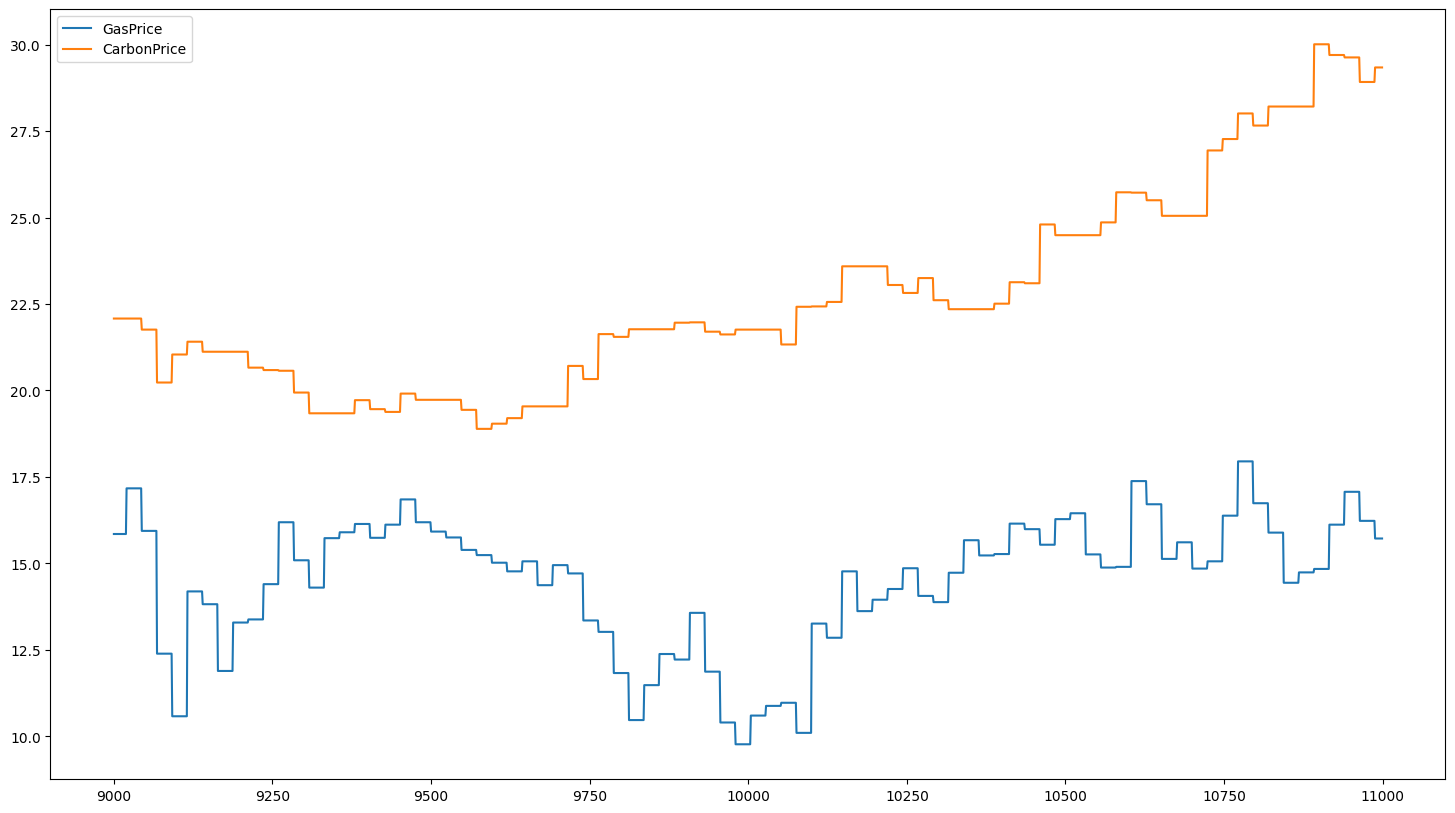

In [18]:
col_names = ['DemandAggregatedForecast', 'WindAggregatedForecast', 'MULTI_FUEL_-24', 'GAS_-24', 'GasPrice','CarbonPrice']
sample_data = data[col_names].iloc[9000:11000,:]

select_col = ['GasPrice', 'CarbonPrice']
plt.figure(figsize=(18, 10))
plt.plot(sample_data[ select_col], label=select_col)
plt.legend()
plt.show()

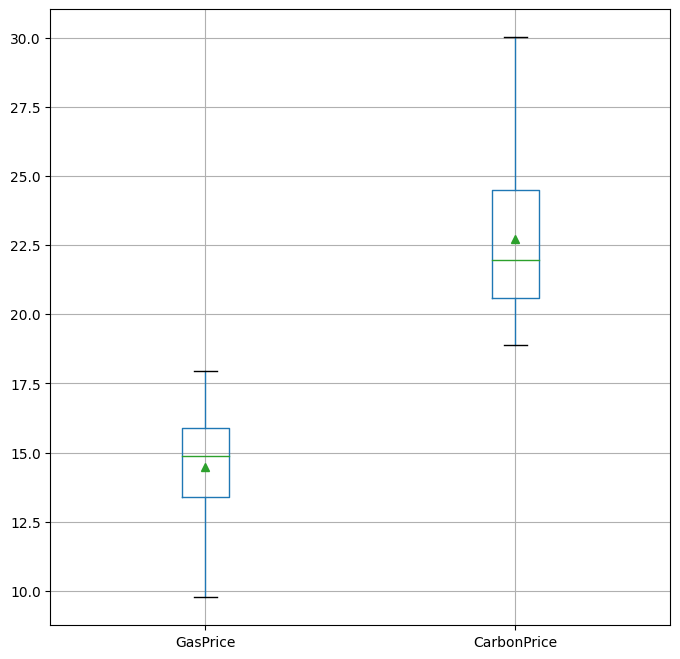

In [19]:

sample_data.boxplot(column=['GasPrice', 'CarbonPrice'], showmeans=True, return_type='axes', figsize=(8, 8))
plt.show()

### 4. Compute the mean cost of the thermal generator and bid prices for the generators

In [20]:
gas_mean_price = sample_data['GasPrice'].mean()
carbon_mean_price = sample_data['CarbonPrice'].mean()
mean_cost = 0.6945*gas_mean_price + 0.39*carbon_mean_price

# low_bid_price =1.0*mean_cost; mid_bid_price =1.5*mean_cost; high_bid_price=2.0*mean_cost
bid_prices = np.around(np.array([0, 1.0, 1.5, 2.0])* mean_cost, 2)
print(bid_prices)


[ 0.   18.92 28.38 37.84]


### 5. Model the generator and power market

In [11]:
class Gencos:
    def __init__(self, id, cost_weights, epsilon, alpha, bid_prices):
        self.id = id
        self.cost_weights = cost_weights # [gas_cost_weight, carbon_cost_weight]
        self.epsilon = epsilon
        self.alpha = alpha
        self.bid_prices = bid_prices
        self.Q = np.zeros(len(self.bid_prices))
        self.Q_history = [self.Q.copy()]

    def bid(self, t, max_t, multi_fuel, gas, wind_aggregated_forcast):
        R = np.random.random()
        # the probility to choose random price: ǫit ←max{0.001,1−(1−e0)(1+ 8t/max_t)}
        epsilon_t = max(0.001, 1 - (1-self.epsilon)*(1 + 8.0*t/max_t))

        # bid with max_Q's price
        if self.Q.sum() > 0 and R > epsilon_t:
            self.bid_index = self.Q.argmax()

        # bid with a random price
        else:
            self.bid_index = np.random.randint(0,len(self.bid_prices))

        bid_price = self.bid_prices[self.bid_index]

        # compute the capacity of the bid
        # wind generator's capacity
        if sum(self.cost_weights) == 0:
            bid_capacity = wind_aggregated_forcast
        # thermal generator's capacity
        else:
            bid_capacity = -1.0*(multi_fuel + gas)/3

        return bid_price, bid_capacity, self.id

    def update_Q(self, t, max_t, success_bid_capacity, clear_price, gas_price, carbon_price):

        self.cost = self.cost_weights[0]*gas_price + self.cost_weights[1]*carbon_price

        # αit =(1− t )(αi0)+(αi0/10)( t )
        alpha_t = (1 - 1.0*t/max_t)*self.alpha + self.alpha*0.1*t/max_t

        # Qij ←(1 − αit)Qij + αit(ri)
        self.Q[self.bid_index] = (1 - alpha_t)*self.Q[self.bid_index] + alpha_t*success_bid_capacity*(clear_price-self.cost)
        self.Q_history.append(self.Q.copy())

class Market:
    def __init__(self, gencos, data) -> None:
        self.gencos = gencos
        self.data = data
        self.clean_prices = []

    def clean_bids(self, t, price_rule='uniform', ration_policy='equal'):
        demond, wind_aggregated_forcast, multi_fuel_24, gas_24,  gas_price, carbon_price = self.data.iloc[t,:]
        bid_list = [g.bid(t+1, self.max_t, multi_fuel_24, gas_24, wind_aggregated_forcast) for g in self.gencos]
        print(bid_list)

        total_volume = 0
        clear_price = 0
        bid_result = []

        # sort by price ascending
        bid_list.sort()
        # convert list to np array
        bid_array = np.array(bid_list)
        # grop the bids by bid price
        bid_group = np.split(bid_array, np.unique(bid_array[:, 0], return_index=True)[1][1:])

        # convert bid groups into bid_volume and genco blocks (bid_price, volume_sum)
        price_volume_block = []
        for g in bid_group:
            price_volume_block.append((g[0,0], g[:,1].sum()))

        # clear the bids
        for price, volume in price_volume_block:
            if (total_volume + volume) < demond:
                total_volume += volume
            else:
                # get the clear_price
                clear_price = price
                # get the left volume for clear_price bids
                left_volume = demond - total_volume

                success_bids = [b for b in bid_list if b[0]< clear_price]
                clear_bids = [b for b in bid_list if b[0]== clear_price]
                # get the fail bids and set volume to 0
                fail_bids = [(b[0], 0, b[2]) for b in bid_list if b[0]> clear_price]


                # rationing policy
                ration_bids = []

                # rationing policy = equal
                if ration_policy == 'equal':
                    volume_ratio = left_volume/volume
                    ration_bids = [(b[0], b[1]*volume_ratio, b[2]) for b in clear_bids]

                # rationing policy = random
                if ration_policy == 'random':
                    while left_volume > 0:
                        idx = np.random.randint(len(clear_bids))
                        select_bid = clear_bids[idx]
                        clear_bids.remove(select_bid)
                        if left_volume > select_bid[1]:
                            ration_bids.append(select_bid)
                            left_volume -= select_bid[1]
                        else:
                            select_bid = (select_bid[0], left_volume, select_bid[2])
                            ration_bids.append(select_bid)

                            clear_bids = [(b[0], 0, b[2]) for b in clear_bids]
                            fail_bids.extend(clear_bids)
                            break

                bid_result.extend(success_bids)
                bid_result.extend(ration_bids)
                bid_result.extend(fail_bids)
                break

        # pricing rule
        if price_rule == 'uniform':
            bid_result = [(clear_price, b[1], b[2]) for b in bid_result]

        return bid_result, clear_price, bid_list

    def run(self, max_t=300, price_rule='pay_as_bid', ration_policy='equal' ):
        self.max_t = max_t
        # print('# \tbid_list(price, volum, gencos_id) \t\tclean_price \tsusccess_bids')

        for t in range(max_t):
            demond, wind_aggregated_forcast, multi_fuel_24, gas_24, gas_price, carbon_price  = self.data.iloc[t,:]
            bid_result, clean_price, bid_list = self.clean_bids(t,  price_rule, ration_policy)
            self.clean_prices.append(clean_price)
            print(t+1, '\t', bid_list,  '\t\t\t', clean_price,  '\t\t', bid_result)
            for price, capacity, id in bid_result:
                for g in self.gencos:
                    if g.id == id:
                        g.update_Q(t+1, max_t, capacity, price, gas_price, carbon_price)


### 6. Initialize the 3 thermal generators and 1 wind generator

In [12]:

parameters = [(0, [0.66, 0.39], 0.9, 0.9), (1, [0.69, 0.39], 0.9, 0.9), (2, [0.79, 0.39], 0.9, 0.9), (3, [0, 0], 0.9, 0.9)]
gencos = [Gencos(p[0], p[1], p[2], p[3], bid_prices) for p in parameters]

### 7. Initialize the power market and run simulation

In [13]:
power_market = Market(gencos,sample_data)
power_market.run(max_t=2000)

[(28.38, 1341.3666666666666, 0), (0.0, 1341.3666666666666, 1), (37.84, 1341.3666666666666, 2), (18.92, 796.428, 3)]
1 	 [(0.0, 1341.3666666666666, 1), (18.92, 796.428, 3), (28.38, 1341.3666666666666, 0), (37.84, 1341.3666666666666, 2)] 			 28.38 		 [(0.0, 1341.3666666666666, 1), (18.92, 796.428, 3), (28.38, 616.2053333333333, 0), (37.84, 0, 2)]
[(28.38, 1341.3666666666666, 0), (28.38, 1341.3666666666666, 1), (0.0, 1341.3666666666666, 2), (28.38, 756.802, 3)]
2 	 [(0.0, 1341.3666666666666, 2), (28.38, 756.802, 3), (28.38, 1341.3666666666666, 0), (28.38, 1341.3666666666666, 1)] 			 28.38 		 [(0.0, 1341.3666666666666, 2), (28.38, 294.5398973272165, 3), (28.38, 522.0467180030585, 0), (28.38, 522.0467180030585, 1)]
[(37.84, 1341.7, 0), (0.0, 1341.7, 1), (37.84, 1341.7, 2), (37.84, 770.572, 3)]
3 	 [(0.0, 1341.7, 1), (37.84, 770.572, 3), (37.84, 1341.7, 0), (37.84, 1341.7, 2)] 			 37.84 		 [(0.0, 1341.7, 1), (37.84, 304.371714536192, 3), (37.84, 529.9641427319041, 0), (37.84, 529.96414273190

### 8. Plot the Q values of each generator

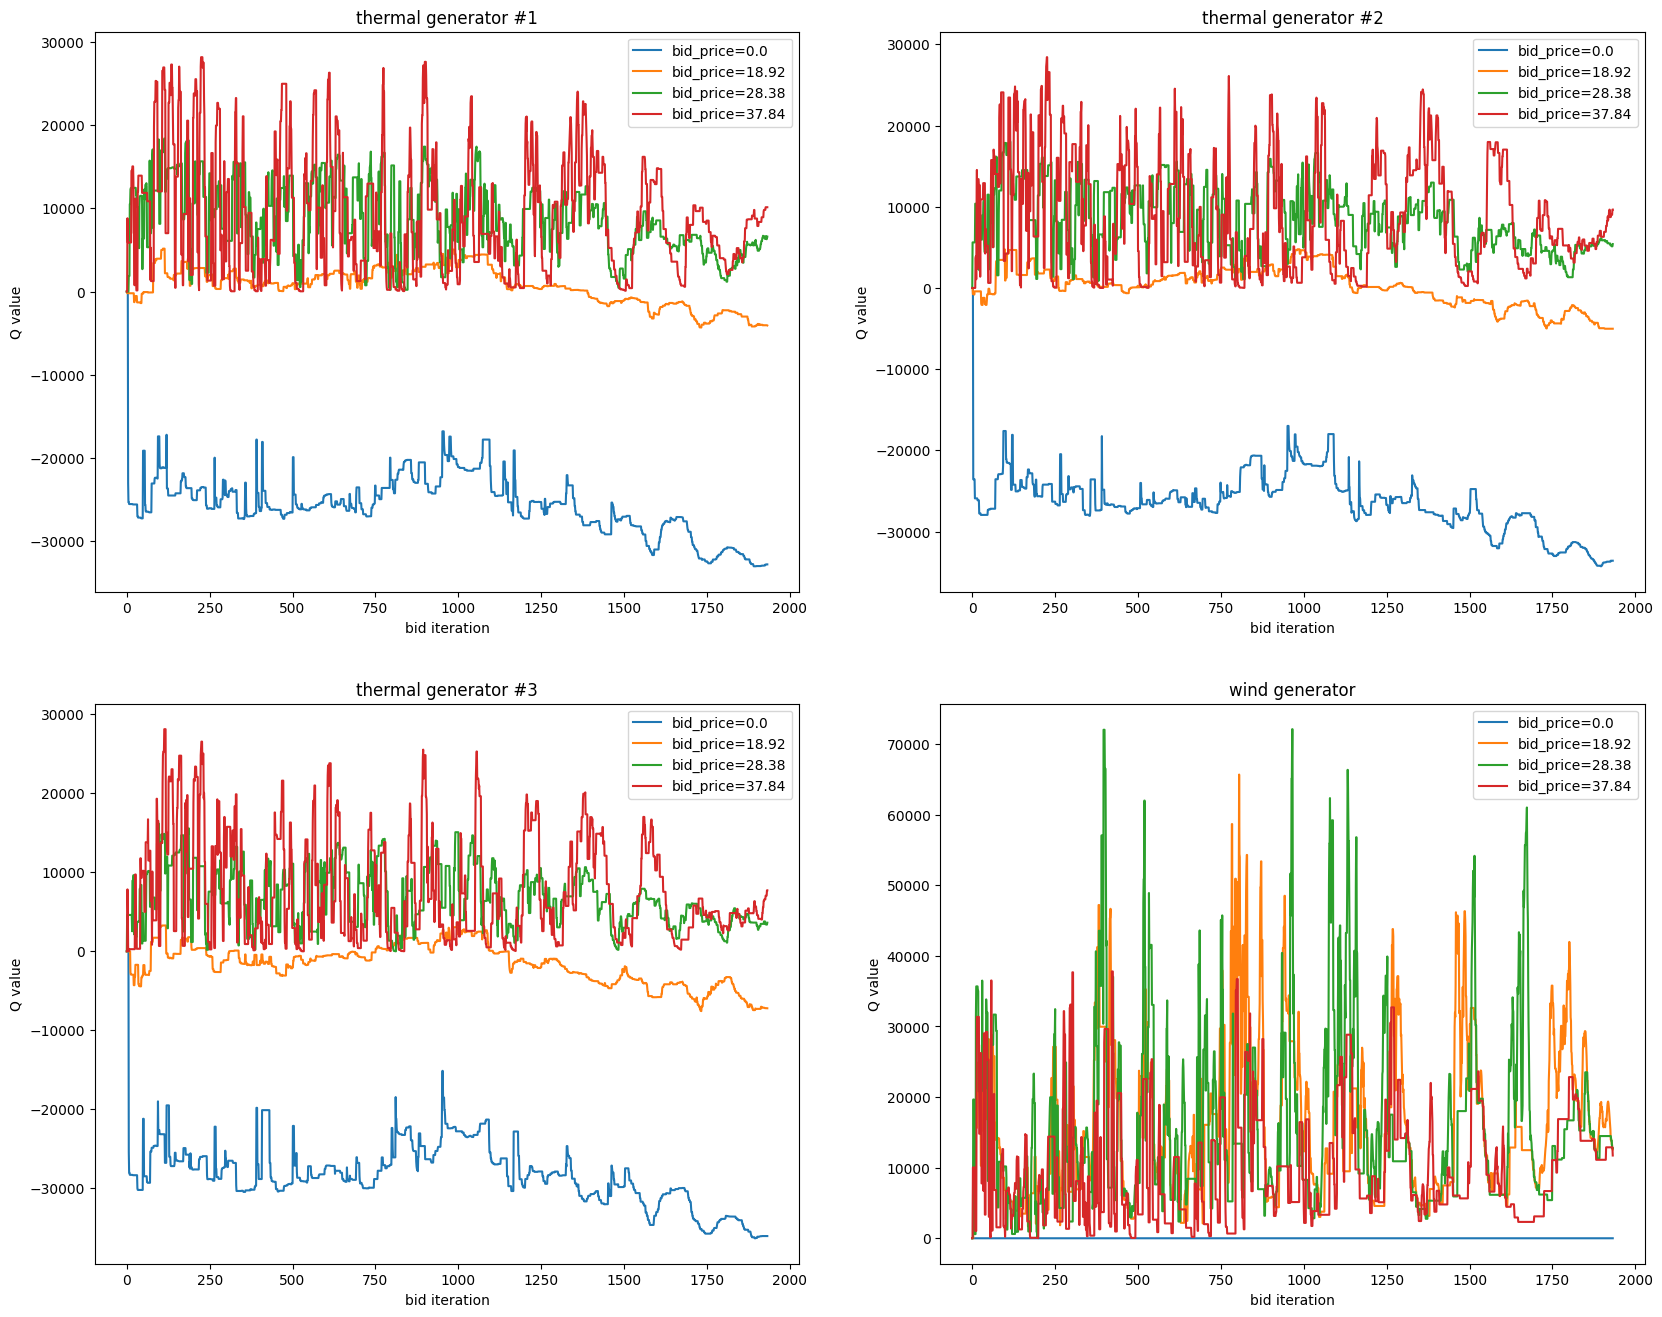

In [ ]:
titles = ['thermal generator #1', 'thermal generator #2', 'thermal generator #3', 'wind generator']
figure = plt.figure(figsize=(20, 16))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(gencos[i].Q_history, label=[f'bid_price={p}' for p in bid_prices])
    plt.legend()
    plt.title(f'{titles[i]}')
    plt.xlabel('bid iteration')
    plt.ylabel('Q value')
    # plt.show()


### 9. Plot the market clean price

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


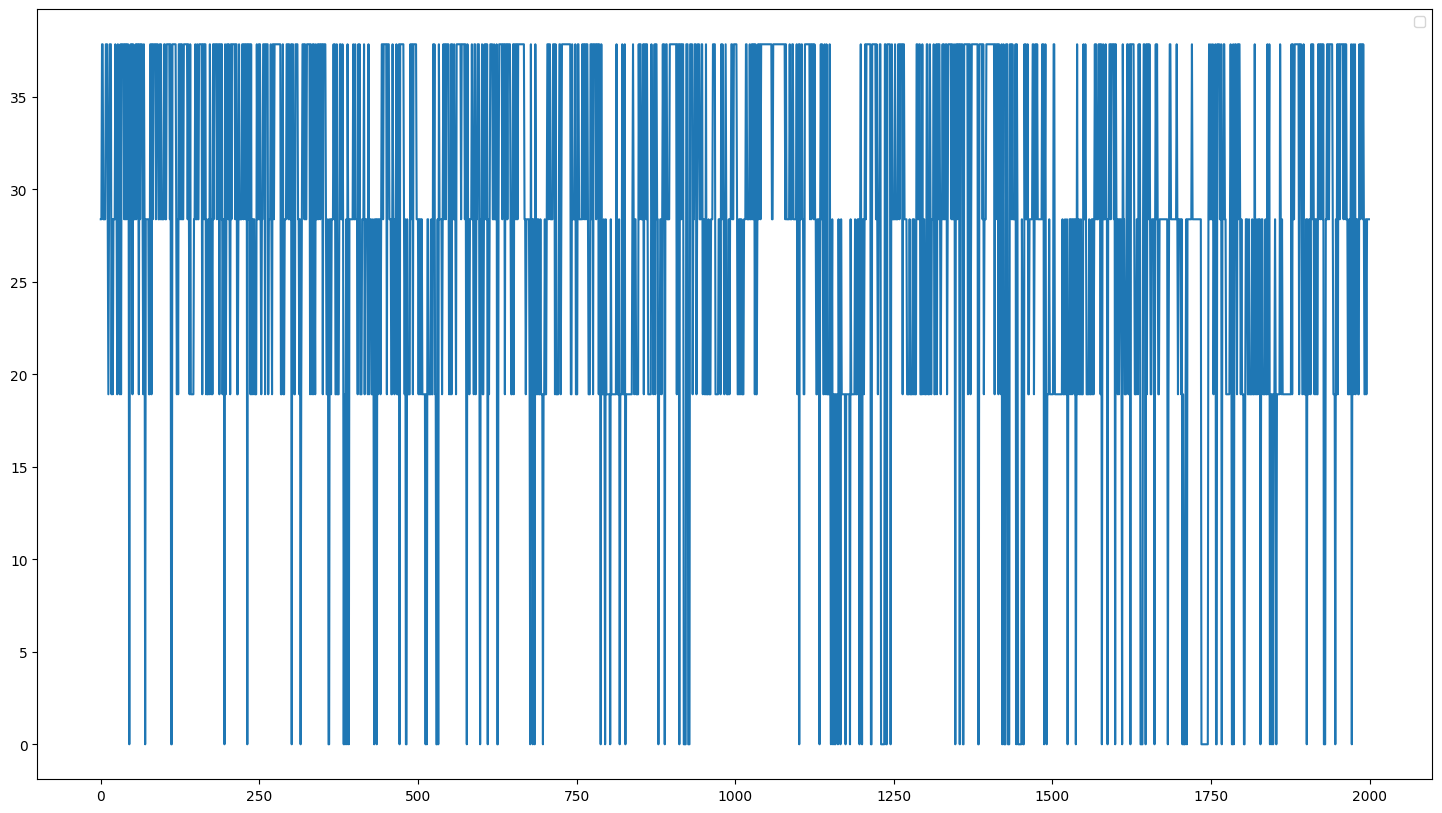

In [14]:
plt.figure(figsize=(18, 10))
plt.plot(power_market.clean_prices)
plt.legend()
plt.show()
